<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/weights/weight_variance_inits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:
- Initialize weights to be Gaussian random numbers, with standard deviations between .0001 and 10 in 25 logarithmic steps (build 25 models and train 25 times to run this experiment).
- Create histograms (count vs. weights) from all weights across all layers (after all training). Use 80 bins for all histograms.

In [24]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import time

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [25]:
# import dataset (comes with colab):
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # np array
print(data.shape)

# extract labels, then remove the labels from data:
labels = data[:,0]
data   = data[:,1:]

# normalize the data:
dataNorm = data / np.max(data) # np array

(20000, 785)


In [26]:
# 1. np array -> torch tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# 2. use scikitlearn to split data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

# 3. torch tensor -> torch dataset obj (combine)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# 4. torch dataset obj -> torch dataloader obj (shuffle)
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([18000, 784]) torch.Size([18000]) torch.Size([2000, 784]) torch.Size([2000])


In [27]:
def createTheMNISTNet():

  # create a class for the model:
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### fully connected hidden layers
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance:
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [28]:
def function2trainTheModel(net,lossfun,optimizer):

  numepochs = 10

  # initialization:
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  for epochi in range(numepochs):

    net.train() # switch on train mode
    batchLoss = []
    batchAcc  = []

    # loop over training data batches
    for X,y in train_loader:

      # forward pass
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad() # zero out gradients from the prev iteration
      loss.backward() # calculates gradients of the loss
      optimizer.step() # update weights based on the calculated gradients

      # record
      batchLoss.append(loss.item())
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # average training losses and acc across batches
    losses[epochi] = np.mean(batchLoss)
    trainAcc.append( np.mean(batchAcc) )

    net.eval() # switch to eval mode

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Start the expt!

In [29]:
# range of standard deviations
stdevs = np.logspace(np.log10(.0001),np.log10(10),25) # np array

# number of histogram bins for plotting distributions
nhistBins = 80

# initialize results output matrix
accresults = np.zeros(len(stdevs))
histodata  = np.zeros((len(stdevs),2,nhistBins))

# Start the timer!
startTime = time.process_time()

# now to really start the experiment
for idx,std in enumerate(stdevs):

  net,lossfun,optimizer = createTheMNISTNet() # init to default random weights

  # set all parameters according to the standard deviation
  for p in net.named_parameters():
    p[1].data = torch.randn_like( p[1].data ) * std # parameter name: p[0], parameter value: p[1]

  # train the model
  trainAcc,testAcc,losses,net = function2trainTheModel(net,lossfun,optimizer)

  # get test accuracy on final 3 runs (averaging increases stability)
  accresults[idx] = np.mean( testAcc[-3:] )

  # collect all parameters into one vector and compute its histogram
  tmpparams = np.array([]) # empty np array
  for p in net.named_parameters():
    tmpparams = np.concatenate( (tmpparams,p[1].data.numpy().flatten()),axis=0 ) # flatten np matrix to vector

  # now compute their histogram
  y,x = np.histogram(tmpparams,nhistBins)
  histodata[idx,0,:] = (x[1:]+x[:-1])/2
  histodata[idx,1,:] = y

  # status report
  timeElapsed = time.process_time() - startTime
  print(f'Finished {idx+1}/{len(stdevs)} after {timeElapsed:3.0f}s. Model accuracy was {accresults[idx]:.2f}%.')

Finished 1/25 after  19s. Model accuracy was 93.43%.
Finished 2/25 after  37s. Model accuracy was 10.60%.
Finished 3/25 after  53s. Model accuracy was 92.28%.
Finished 4/25 after  69s. Model accuracy was 94.40%.
Finished 5/25 after  85s. Model accuracy was 93.48%.
Finished 6/25 after 101s. Model accuracy was 94.00%.
Finished 7/25 after 118s. Model accuracy was 93.05%.
Finished 8/25 after 134s. Model accuracy was 94.27%.
Finished 9/25 after 149s. Model accuracy was 94.00%.
Finished 10/25 after 165s. Model accuracy was 93.92%.
Finished 11/25 after 181s. Model accuracy was 93.77%.
Finished 12/25 after 196s. Model accuracy was 93.68%.
Finished 13/25 after 212s. Model accuracy was 94.57%.
Finished 14/25 after 227s. Model accuracy was 94.62%.
Finished 15/25 after 242s. Model accuracy was 94.20%.
Finished 16/25 after 257s. Model accuracy was 95.13%.
Finished 17/25 after 272s. Model accuracy was 94.23%.
Finished 18/25 after 287s. Model accuracy was 94.63%.
Finished 19/25 after 301s. Model accu

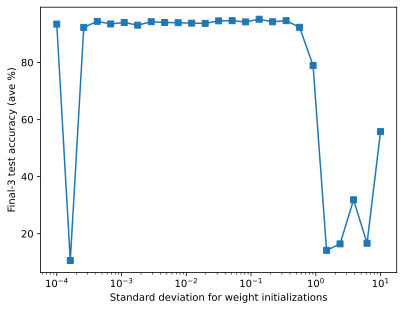

In [32]:
# show the results:

plt.plot(stdevs,accresults,'s-')
plt.xlabel('Standard deviation for weight initializations')
plt.ylabel('Final-3 test accuracy (ave %)')
plt.xscale('log')
# plt.ylim([80,100])
plt.show()

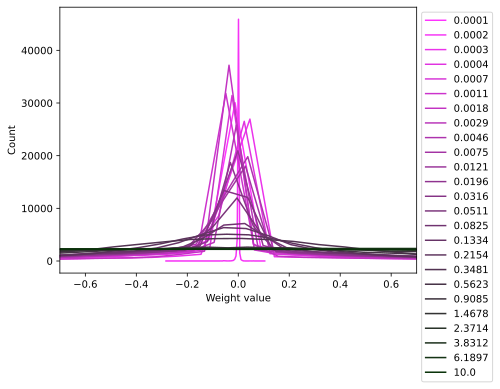

In [35]:
# show the weights distributions

for i in range(len(stdevs)):
  plt.plot(histodata[i,0,:],histodata[i,1,:],color=[1-i/len(stdevs),.2,1-i/len(stdevs)])

plt.xlabel('Weight value')
plt.ylabel('Count')
plt.legend(np.round(stdevs,4),bbox_to_anchor=(1,1),loc='upper left')
plt.xlim([-0.7,0.7])
plt.show()